<a href="https://colab.research.google.com/github/wcl20/Kaggle-Titanic/blob/master/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Kaggle Titanic**

## 1. Setup

In [ ]:
!pip install tensorflow-gpu==2.0.0

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from google.colab import files

np.random.seed(0)

In [3]:
tf.__version__

'2.0.0'

## 2. Load Data

### 2.1 Upload Kaggle API

In [ ]:
files.upload()

### 2.2 Fetch Data

In [5]:
# Install Kaggle
! pip install -U -q kaggle
# Create Kaggle Directory
! mkdir -p ~/.kaggle
# Copy API key to Kaggle Directory
! cp kaggle.json ~/.kaggle/
# Change permission of file
! chmod 600 ~/.kaggle/kaggle.json
# Download dataset
! kaggle competitions download -c titanic
! unzip titanic.zip -d data

     |████████████████████████████████| 61kB 3.0MB/s 
  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 30.9MB/s]
Archive:  titanic.zip
  inflating: data/gender_submission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          


### 2.3 Training Data

In [6]:
train_dataset = pd.read_csv("./data/train.csv")
train_dataset.head(20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [7]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### 2.4 Test Data

In [8]:
test_dataset = pd.read_csv("./data/test.csv")
test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


### 2.5 Preprocess Data

In [9]:
dataset = pd.concat([train_dataset, test_dataset], axis=0)
# Remove irrlevant columns
dataset.drop(columns=['PassengerId', 'Ticket', 'Cabin'], inplace=True)
# Normalize features
scaler = StandardScaler()
for feature in ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']:
  dataset[feature] = dataset[feature].fillna(dataset[feature].mean())
  dataset[feature] = scaler.fit_transform(dataset[feature].values.reshape(-1, 1))

In [10]:
# Extract Title from Name 
dataset['Title'] = dataset['Name'].str.extract('([A-Za-z]+)\.')
dataset['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [11]:
dataset['Title'].replace(['Mr', ], 'Mr', inplace=True)
dataset['Title'].replace(['Miss', 'Ms', 'Mlle'], 'Ms', inplace=True)
dataset['Title'].replace(['Mrs', 'Mme', 'Dona'], 'Mrs', inplace=True)
dataset['Title'].replace(['Don', 'Sir', 'Jonkheer', 'Major', 'Col', 'Capt'], 'Sir', inplace=True)
dataset['Title'].replace(['Lady', 'Countess'], 'Lady', inplace=True)
dataset['Title'].unique()

array(['Mr', 'Mrs', 'Ms', 'Master', 'Sir', 'Rev', 'Dr', 'Lady'],
      dtype=object)

In [12]:
# Change title to one hot encoding
title = pd.get_dummies(dataset['Title'], prefix='Title')
dataset = pd.concat([dataset, title], axis=1)
dataset.drop(columns=['Name', 'Title'], inplace=True)

In [13]:
# Change sex to binary 
dataset['Sex'] = dataset['Sex'].astype('category')
dataset['Sex'] = dataset['Sex'].cat.codes

In [14]:
# Change embark to one hot encoding
embarked = pd.get_dummies(dataset['Embarked'], prefix='Embarked')
dataset = pd.concat([dataset, embarked], axis=1)
dataset.drop(columns=['Embarked'], inplace=True)

In [15]:
dataset.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Title_Dr,Title_Lady,Title_Master,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Embarked_C,Embarked_Q,Embarked_S
0,0.0,0.841916,1,-0.611972,0.481288,-0.445000,-0.503595,0,0,0,1,0,0,0,0,0,0,1
1,1.0,-1.546098,0,0.630431,0.481288,-0.445000,0.734503,0,0,0,0,1,0,0,0,1,0,0
2,1.0,0.841916,0,-0.301371,-0.479087,-0.445000,-0.490544,0,0,0,0,0,1,0,0,0,0,1
3,1.0,-1.546098,0,0.397481,0.481288,-0.445000,0.382925,0,0,0,0,1,0,0,0,0,0,1
4,0.0,0.841916,1,0.397481,-0.479087,-0.445000,-0.488127,0,0,0,1,0,0,0,0,0,0,1
5,0.0,0.841916,1,0.000000,-0.479087,-0.445000,-0.480232,0,0,0,1,0,0,0,0,0,1,0
6,0.0,-1.546098,1,1.872834,-0.479087,-0.445000,0.358997,0,0,0,1,0,0,0,0,0,0,1
7,0.0,0.841916,1,-2.164975,2.402037,0.710763,-0.236286,0,0,1,0,0,0,0,0,0,0,1
8,1.0,0.841916,0,-0.223721,-0.479087,1.866526,-0.428510,0,0,0,0,1,0,0,0,0,0,1
9,1.0,-0.352091,0,-1.233173,0.481288,-0.445000,-0.062350,0,0,0,0,1,0,0,0,1,0,0


In [16]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Survived      891 non-null    float64
 1   Pclass        1309 non-null   float64
 2   Sex           1309 non-null   int8   
 3   Age           1309 non-null   float64
 4   SibSp         1309 non-null   float64
 5   Parch         1309 non-null   float64
 6   Fare          1309 non-null   float64
 7   Title_Dr      1309 non-null   uint8  
 8   Title_Lady    1309 non-null   uint8  
 9   Title_Master  1309 non-null   uint8  
 10  Title_Mr      1309 non-null   uint8  
 11  Title_Mrs     1309 non-null   uint8  
 12  Title_Ms      1309 non-null   uint8  
 13  Title_Rev     1309 non-null   uint8  
 14  Title_Sir     1309 non-null   uint8  
 15  Embarked_C    1309 non-null   uint8  
 16  Embarked_Q    1309 non-null   uint8  
 17  Embarked_S    1309 non-null   uint8  
dtypes: float64(6), int8(1), uint8

### 2.3 Split Train and Test Data

In [17]:
train, test = dataset[pd.notnull(dataset['Survived'])], dataset[pd.isnull(dataset['Survived'])]
X_train, y_train = train.values[:, 1:], train.values[:, 0]
X_test = test.values[:, 1:]

In [18]:
X_train.shape

(891, 17)

## 3. Model

### 3.1 Define Model

In [19]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=128, kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(17, )))
model.add(tf.keras.layers.LeakyReLU(alpha=0.1))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units=256, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(tf.keras.layers.LeakyReLU(alpha=0.1))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units=512, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(tf.keras.layers.LeakyReLU(alpha=0.1))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units=256, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(tf.keras.layers.LeakyReLU(alpha=0.1))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units=128, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(tf.keras.layers.LeakyReLU(alpha=0.1))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

### 3.2 Create Model

In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               2304      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1

### 3.3 Train Model

In [21]:
training = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, verbose=0)

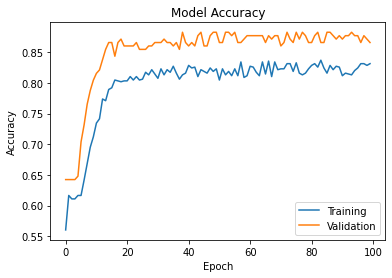

In [22]:
plt.plot(training.history['accuracy'], label='Training')
plt.plot(training.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## 4. Test Model

In [23]:
X_test.shape

(418, 17)

In [24]:
test_dataset['Survived'] = (model.predict(X_test) > 0.5).astype("int32")
test_dataset.head(30)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S,0
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q,1
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S,0
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C,1
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S,0


In [25]:
test_dataset[['PassengerId', 'Survived']].to_csv('submission.csv', index=False)

## 5. Save Model

### 5.1 Save architecture

In [26]:
with open("model.json", "w") as file:
    file.write(model.to_json())

### 5.2 Save weights

In [27]:
model.save_weights("model.h5")